In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# defining global settings :
pd.set_option('display.max_columns' , None)
sns.set_style('darkgrid')

# Data Exploration

## Basic structure of the dataset

In [2]:
# Loading the dataset :
df = pd.read_csv("/content/dataset_phishing.csv")

In [3]:
# Basic info about the dataset :
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

## Inspecting target classes distribution

status
legitimate    5715
phishing      5715
Name: count, dtype: int64


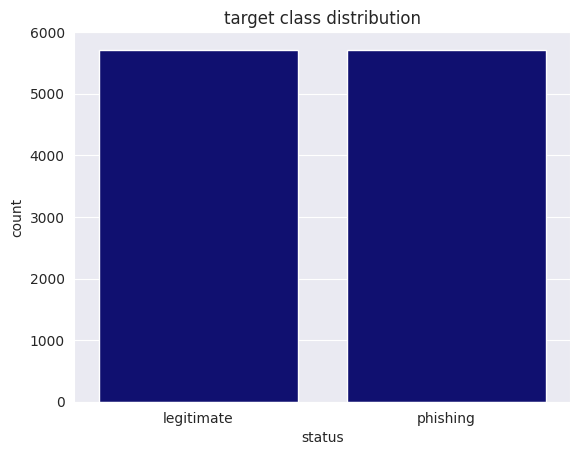

In [4]:
# Checking wether the target variable is balanced :
print(df['status'].value_counts())

sns.countplot(data = df , x = 'status' , color = 'navy')
plt.title('target class distribution')
plt.show()

# comment : The target variable classes are balanced.

## Inspecting missing values

In [5]:
# Inspect the dataset for missing values :

missing_counts = df.isnull().sum()
missing_counts[missing_counts > 0]

# Comment :  No missing values are present in the dataset

,0


## Summary statistics of the dataset

In [6]:
# Summary statistics of the dataset :
description = df.describe().T
description.sort_values(by = 'std' , ascending = False)

# Features with high variance have more potential to distinguish between classes.

,count,mean,std,min,25%,50%,75%,max
web_traffic,11430.0,856756.643307,1.995606e+06,0.0,0.00,1651.0,373845.50,10767986.0
domain_age,11430.0,4062.543745,3.107785e+03,-12.0,972.25,3993.0,7026.75,12874.0
domain_registration_length,11430.0,492.532196,8.147694e+02,-1.0,84.00,242.0,449.00,29829.0
nb_hyperlinks,11430.0,87.189764,1.667583e+02,0.0,9.00,34.0,101.00,4659.0
length_url,11430.0,61.126684,5.529732e+01,12.0,33.00,47.0,71.00,1641.0
...,...,...,...,...,...,...,...,...
ratio_intRedirection,11430.0,0.000000,0.000000e+00,0.0,0.00,0.0,0.00,0.0
submit_email,11430.0,0.000000,0.000000e+00,0.0,0.00,0.0,0.00,0.0
ratio_intErrors,11430.0,0.000000,0.000000e+00,0.0,0.00,0.0,0.00,0.0
ratio_nullHyperlinks,11430.0,0.000000,0.000000e+00,0.0,0.00,0.0,0.00,0.0


### **Comment :** The dataset presents some features with null variance, these features should be removed

In [7]:
# identify the features with zero standard deviation :

def drop_zero_var_cols(df : pd.DataFrame  , tr = 1e-2 ) -> pd.DataFrame :

  # extract the columns list :
  cols = df.columns.to_list()
  # identify columns to remove :
  cols = [col for col in cols if (df[col].dtype != 'object' and df[col].std() <= tr)]
  # drop identified columns :
  df.drop(columns=cols , inplace = True)

  return df

In [8]:
df = drop_zero_var_cols(df)

df.describe().T.sort_values(by = 'std')['std']

# comment : featurs with zero variance are successully removed

,std
path_extension,1.322735e-02
punycode,1.870466e-02
nb_star,2.644776e-02
onmouseover,3.370703e-02
iframe,3.620398e-02
...,...
length_url,5.529732e+01
nb_hyperlinks,1.667583e+02
domain_registration_length,8.147694e+02
domain_age,3.107785e+03


## Correlation analysis

In [9]:
# Transforming the large correlation matrix into a dataframe for better manipulation

def corr_matrix2df(df : pd.DataFrame) -> pd.DataFrame :

  # calculate correlation :
  corr_matrix = df.corr(numeric_only=True)

  # flatten correlation matrix :
  corr_matrix = corr_matrix.unstack().reset_index()
  corr_matrix.columns = ['feature_1' , 'feature_2' , 'correlation']

  # remove self correlations and duplicates (keep only X-Y or Y-X) :
  corr_matrix = corr_matrix[corr_matrix['correlation'] < 1].drop_duplicates()

  # return the processed correlation matrix :
  return corr_matrix


In [10]:
corr_matrix = corr_matrix2df(df)
corr_matrix.duplicated().sum()

np.int64(0)

In [11]:
corr_matrix['feature_1'].duplicated().sum()

np.int64(6399)

### **comment** : we notice the existence of some very highly correlated features, which will help us reduce the dimensionality of the dataset even further.

In [12]:
# perfming dimensionality reduction based on high correlations between features :
def reduce_dim(df : pd.DataFrame , corr_tr : float = 0.9)  -> pd.DataFrame :

  # extract the processed corr matrix :
  corr_matrix = corr_matrix2df(df)

  # identify the rows which fullill the filtering condition :
  corr_matrix = corr_matrix[corr_matrix['correlation'] >= corr_tr]
  cols = list(set(corr_matrix['feature_1']))

  # remove the identified columns and return the processed dataframe :
  return df.drop(columns=cols)

In [13]:
# process the dataframe :
df = reduce_dim(df)
len(df.columns)

79

## Distribution analysis

In [14]:
def identify_relevant_features(df: pd.DataFrame, quantile: float = 0.75) -> list:
    # extract columns list
    cols = df.columns.to_list()

    # compute threshold for high variance
    threshold = df.std(numeric_only=True).quantile(quantile)

    # filter columns with numeric type and high variance
    cols = [col for col in cols if df[col].dtype != 'object' and df[col].std() >= threshold]

    return cols


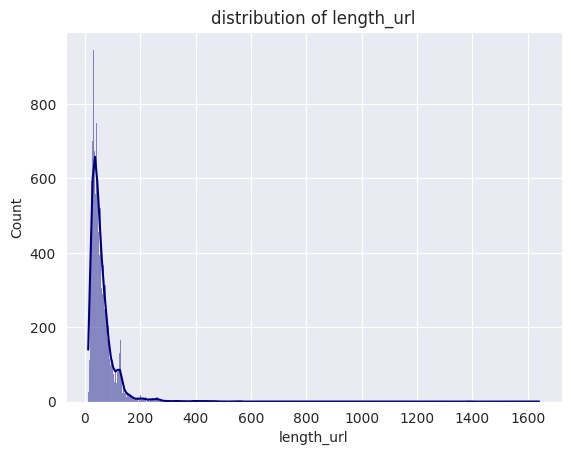

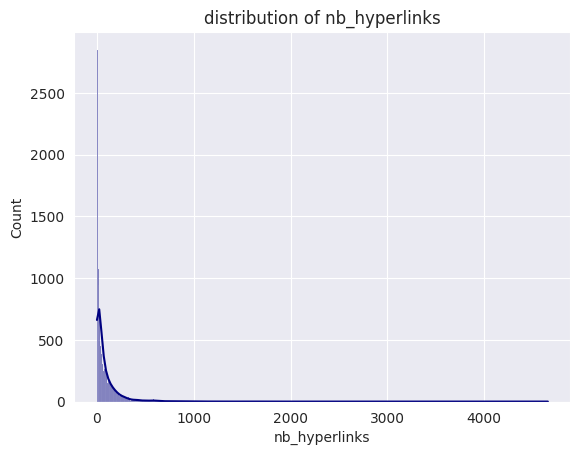

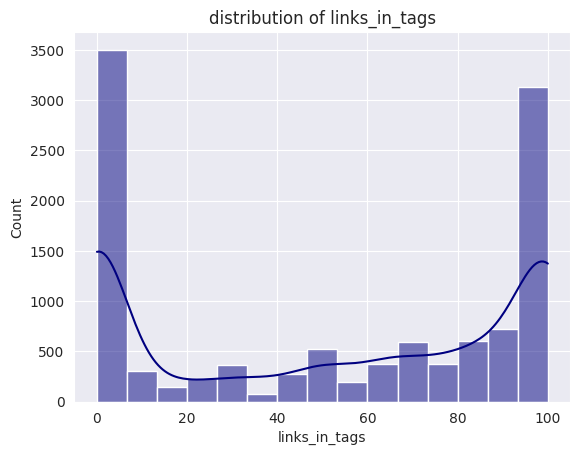

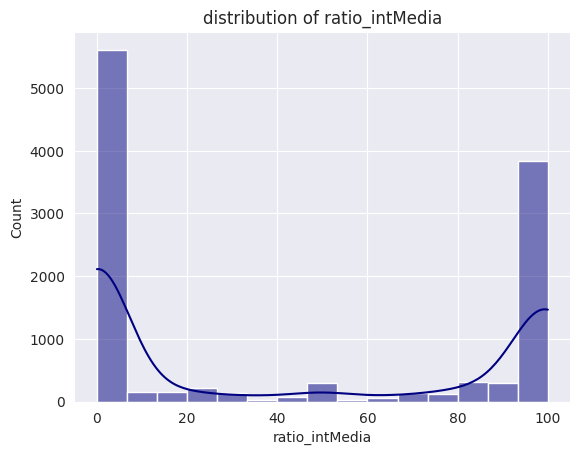

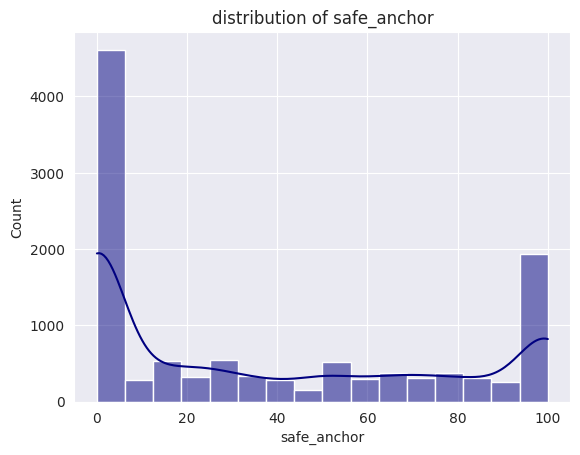

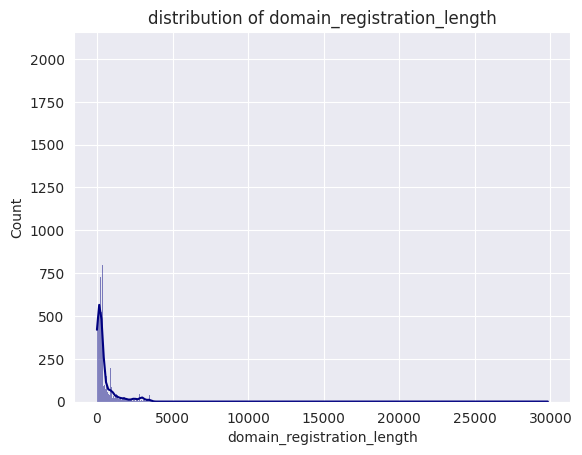

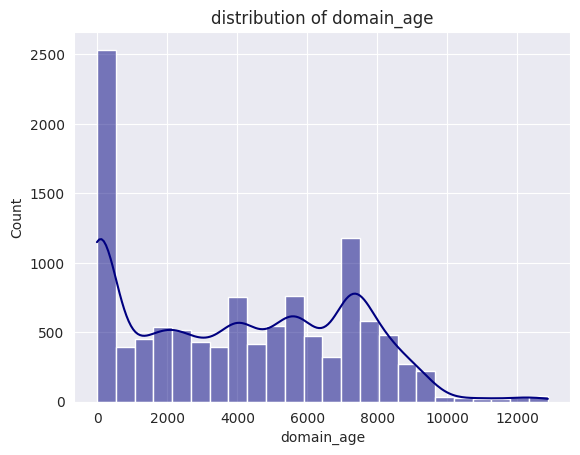

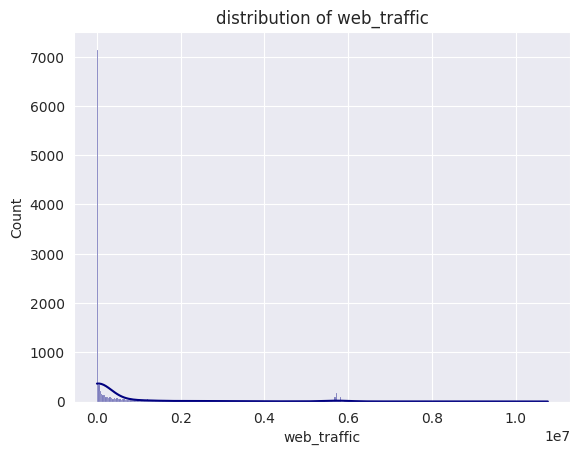

In [15]:
cols = identify_relevant_features(df , quantile=0.9)

for col in cols :
  sns.histplot(data = df , x = col , color = 'navy' , kde = True)
  plt.title(f'distribution of {col}')
  plt.show()

# Data Preprocessing

In [16]:
# droping the url feature since all its properties are represented in other features :
df = df.drop(columns=['url'])
df.columns.to_list()

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_word_host',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyperlinks',
 'nb_extCSS',
 'ratio_extRedirection',
 'ratio_extErrors',
 'logi

### Encoding the categorical variable ( status )

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['status'] = le.fit_transform(y = df['status'])
df['status'].sample(5)

# cetegorical variable encoded successfully

,status
7705,1
8694,1
7523,1
2230,1
5952,0


### Splitting the dataset into features and target

In [18]:
from sklearn.preprocessing import StandardScaler

# split the dataframe into features and target :
X = df.drop(columns = ['status'])
y = df['status']

### Reducing dimenssionality using Principle Component Analysis

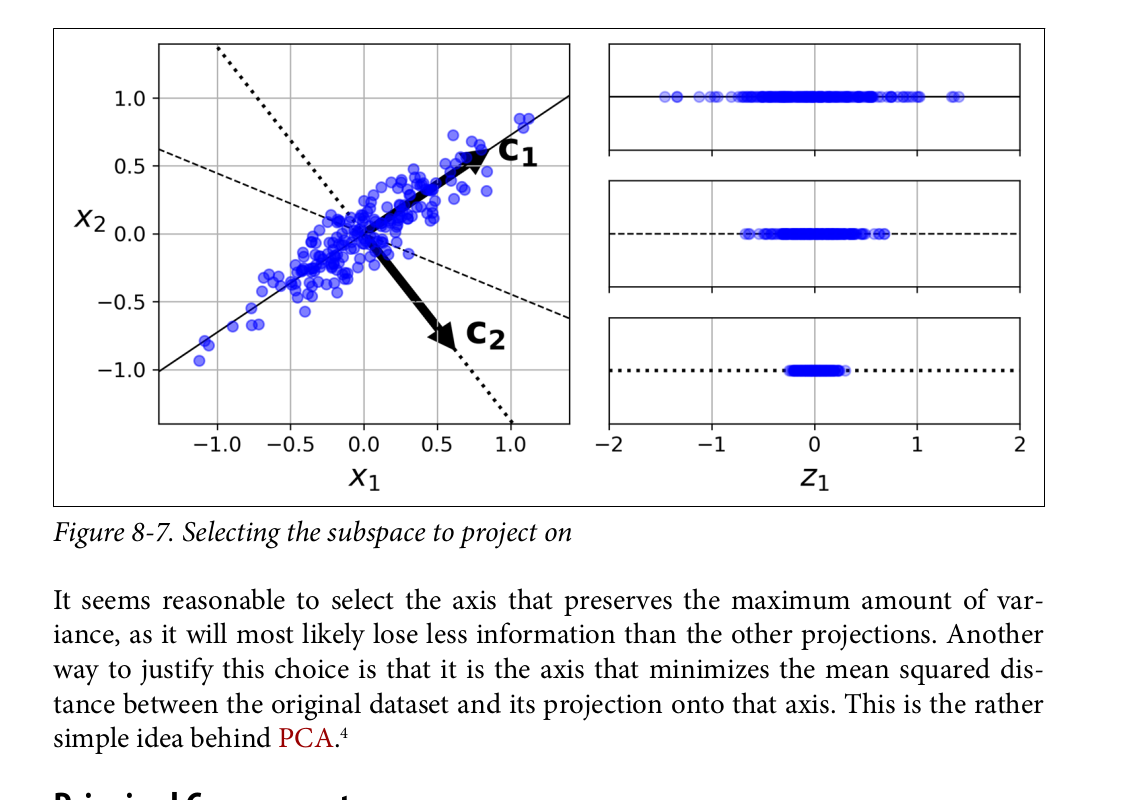

In [19]:
from sklearn.decomposition import PCA

# n_component is chosen after testing different choices and seeing how they impact
# the accuracy of a Logistic regression model
pca = PCA(n_components = 30)
X = pca.fit_transform(X)

#### **The key challenge in PCA is choosing the hyperparameter n_components**

### Train-Test split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test = train_test_split(X , y.to_numpy() , test_size=0.2 , random_state=42 , stratify=y)

# verifying data integrity :
print(f'X_train shape : {X_train.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

# data is ready to be fed to a machine learning classification model

X_train shape : (9144, 30)
X_test shape : (2286, 30)
y_train shape : (9144,)
y_test shape : (2286,)


# Training machine learning models

### Logistic regression classifier

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# pipline for standarizing data and applying the model :
logreg_clf = Pipeline(
    [('scaler' , StandardScaler()) ,
     ('logreg' , LogisticRegression())]
)

logreg_clf.fit(X_train , y_train)

preds = logreg_clf.predict(X_test)

In [22]:
# evaluation of the model
from sklearn.metrics import classification_report

report = classification_report(y_test , preds , target_names=['legit' , 'phishing'] )
print(report)

              precision    recall  f1-score   support

       legit       0.93      0.92      0.92      1143
    phishing       0.92      0.93      0.92      1143

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



### SVM classifier

In [23]:
from sklearn.svm import LinearSVC

svm_clf = Pipeline(
    [('scaler' , StandardScaler()) ,
     ('svc' , LinearSVC())]
)

# train the model on the dataset
svm_clf.fit(X_train , y_train)

# perform predictions :
preds = svm_clf.predict(X_test)

In [24]:
# evaluation of the model
from sklearn.metrics import classification_report

report = classification_report(y_test , preds , target_names=['legit' , 'phishing'] )
print(report)

              precision    recall  f1-score   support

       legit       0.93      0.92      0.93      1143
    phishing       0.92      0.93      0.93      1143

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



### Decision tree classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = Pipeline(
    [('scaler' , StandardScaler()) ,
     ('svc' , DecisionTreeClassifier())]
)

tree_clf.fit(X_train , y_train)
preds = tree_clf.predict(X_test)


In [26]:
# evaluation of the model
from sklearn.metrics import classification_report

report = classification_report(y_test , preds , target_names=['legit' , 'phishing'] )
print(report)

              precision    recall  f1-score   support

       legit       0.90      0.89      0.89      1143
    phishing       0.89      0.90      0.89      1143

    accuracy                           0.89      2286
   macro avg       0.89      0.89      0.89      2286
weighted avg       0.89      0.89      0.89      2286



### Voting classifier

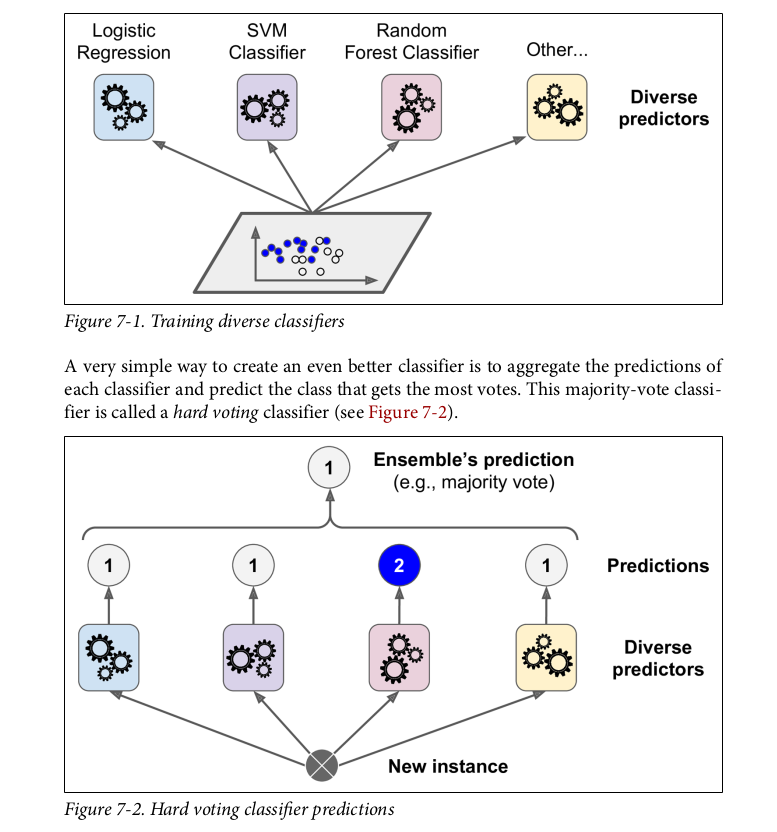

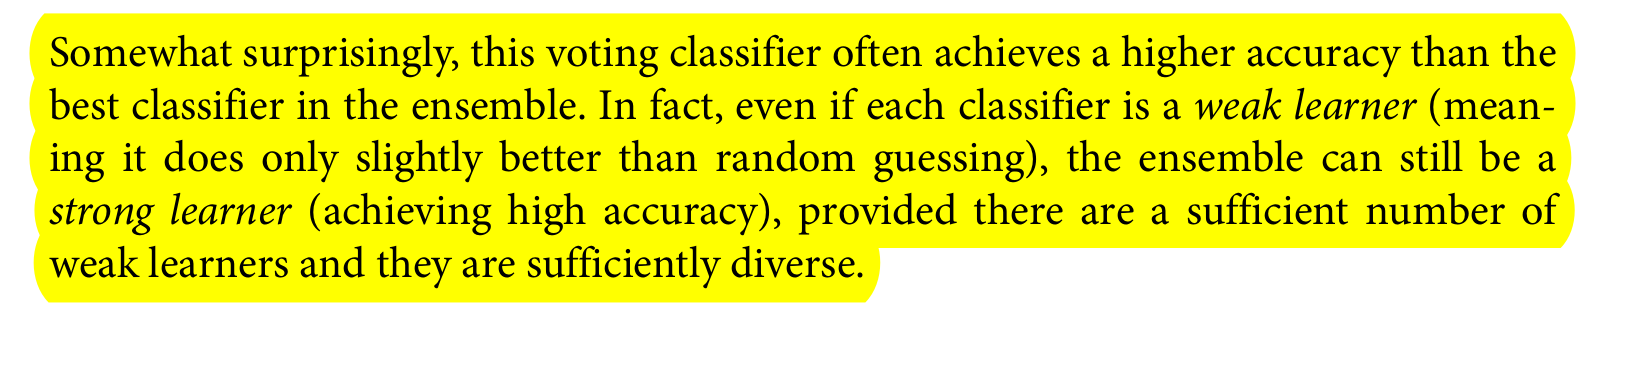

In [36]:
from sklearn.ensemble import VotingClassifier

# instanciating the weak learneers :
logreg_clf = LogisticRegression()

svm_clf = LinearSVC()

tree_clf = DecisionTreeClassifier()

# creating an ensemble classifier based on the selected models :
voting_clf = VotingClassifier(

    estimators= [('logreg_clf' , logreg_clf) , ('svc' , svm_clf) , ('tree_clf' , tree_clf)] ,

    voting = 'hard'
)

# creating a pipeline :
ensemble = Pipeline(
    [('scaler' ,  StandardScaler()) ,
     ('voting' , voting_clf)]
)

ensemble.fit(X_train , y_train)
preds = ensemble.predict(X_test)

In [37]:
# evaluation of the model
from sklearn.metrics import classification_report

report = classification_report(y_test , preds , target_names=['legit' , 'phishing'] )
print(report)

              precision    recall  f1-score   support

       legit       0.93      0.92      0.92      1143
    phishing       0.92      0.93      0.93      1143

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286

